In [1]:
import random

import matplotlib.pyplot as plt
import missingno as mn
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from catboost import CatBoostClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from lightgbm import LGBMClassifier
from sklearn.ensemble import (
    AdaBoostClassifier,
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.model_selection import (
    KFold,
    StratifiedKFold,
    StratifiedShuffleSplit,
    cross_val_score,
)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, StandardScaler
from xgboost import XGBClassifier

seed = 42
np.random.seed(seed)
random.seed(seed)
pd.set_option("display.max_columns", 50)
from termcolor import colored

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject
/home/balde/miniconda3/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
train = pd.read_csv("training.csv")
test = pd.read_csv("test.csv")
train.head()

,TransactionId,BatchId,AccountId,SubscriptionId,CustomerId,CurrencyCode,CountryCode,ProviderId,ProductId,ProductCategory,ChannelId,Amount,Value,TransactionStartTime,PricingStrategy,FraudResult
0,TransactionId_76871,BatchId_36123,AccountId_3957,SubscriptionId_887,CustomerId_4406,UGX,256,ProviderId_6,ProductId_10,airtime,ChannelId_3,1000.0,1000,2018-11-15T02:18:49Z,2,0
1,TransactionId_73770,BatchId_15642,AccountId_4841,SubscriptionId_3829,CustomerId_4406,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-20.0,20,2018-11-15T02:19:08Z,2,0
2,TransactionId_26203,BatchId_53941,AccountId_4229,SubscriptionId_222,CustomerId_4683,UGX,256,ProviderId_6,ProductId_1,airtime,ChannelId_3,500.0,500,2018-11-15T02:44:21Z,2,0
3,TransactionId_380,BatchId_102363,AccountId_648,SubscriptionId_2185,CustomerId_988,UGX,256,ProviderId_1,ProductId_21,utility_bill,ChannelId_3,20000.0,21800,2018-11-15T03:32:55Z,2,0
4,TransactionId_28195,BatchId_38780,AccountId_4841,SubscriptionId_3829,CustomerId_988,UGX,256,ProviderId_4,ProductId_6,financial_services,ChannelId_2,-644.0,644,2018-11-15T03:34:21Z,2,0


<AxesSubplot:>

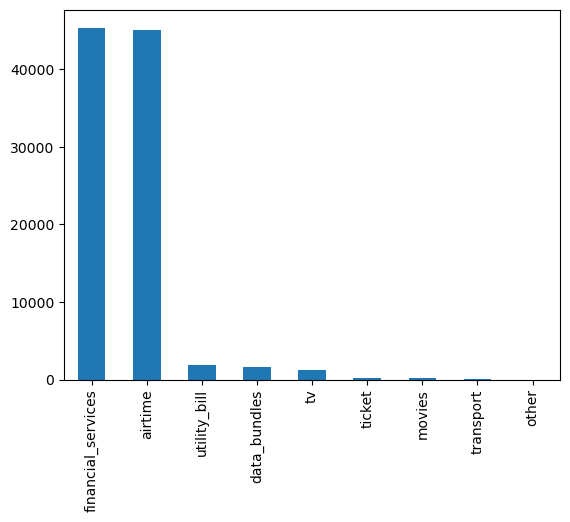

In [3]:
train["ProductCategory"].value_counts().plot(kind="bar")

<AxesSubplot:>

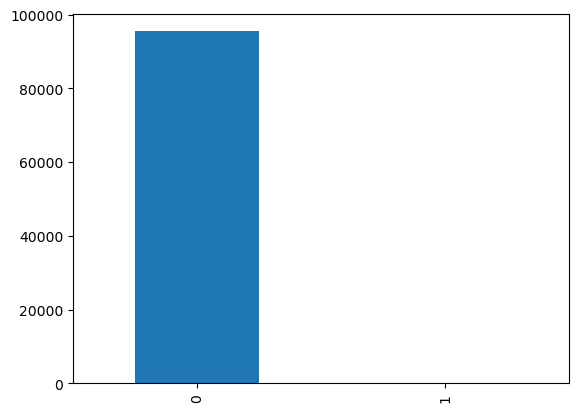

In [4]:
train["FraudResult"].value_counts().plot(kind="bar")

In [5]:
def to_category(df):

    for col in df.columns:
        if df[col].dtypes == "object":
            df[col] = df[col].astype("category")
    return df


train = to_category(train)
test = to_category(test)

In [6]:
train.dtypes

TransactionId           category
BatchId                 category
AccountId               category
SubscriptionId          category
CustomerId              category
CurrencyCode            category
CountryCode                int64
ProviderId              category
ProductId               category
ProductCategory         category
ChannelId               category
Amount                   float64
Value                      int64
TransactionStartTime    category
PricingStrategy            int64
FraudResult                int64
dtype: object

In [7]:
cat_col = [
    "TransactionId",
    "BatchId",
    "AccountId",
    "SubscriptionId",
    "CustomerId",
    "CurrencyCode",
    "ProviderId",
    "ProductId",
    "ProductCategory",
    "ChannelId",
    "TransactionStartTime",
]

In [9]:
X = train.drop("FraudResult", axis=1)
y = train.FraudResult

In [11]:
err = []
y_pred_totcb = []

fold = StratifiedKFold(n_splits=10, random_state=seed, shuffle=True)
for train_index, test_index in fold.split(X, y):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    m1 = LGBMClassifier()
    m1.fit(
        X_train,
        y_train,
        eval_set=[(X_test, y_test)],
        verbose=100,
    )
    preds = m1.predict(X_test)
    print("err: ", f1_score(y_test, preds))
    err.append(f1_score(y_test, preds))
    p2 = m1.predict(test)
    y_pred_totcb.append(p2)
np.mean(err)

/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's binary_logloss: 0.140798
err:  0.04878048780487805


/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's binary_logloss: 0.00944867
err:  0.8205128205128205


/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's binary_logloss: 0.0401945
err:  0.6976744186046512


/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's binary_logloss: 0.0141479
err:  0.7692307692307692


/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's binary_logloss: 0.0202869
err:  0.7878787878787878


/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's binary_logloss: 0.00137312
err:  0.9142857142857143


/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's binary_logloss: 0.00263458
err:  0.918918918918919


/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's binary_logloss: 0.00267629
err:  0.918918918918919


/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's binary_logloss: 0.0833961
err:  0.25


/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1433: UserWarning: Overriding the parameters from Reference Dataset.
  _log_warning('Overriding the parameters from Reference Dataset.')
/home/balde/miniconda3/lib/python3.9/site-packages/lightgbm/basic.py:1245: UserWarning: categorical_column in param dict is overridden.
  _log_warning('{} in param dict is overridden.'.format(cat_alias))


[100]	valid_0's binary_logloss: 0.000579032
err:  0.975609756097561


0.7101810592253021

In [1]:
import numpy as np
import pandas as pd
import sklearn

In [4]:
from typing import Any


def add(a: Any, b: Any):
    return a + b


a = "Hello"
b = " world"
add(a,b)
print("\n")
add(3,9)

12